# Mô hình hồi quy phân cấp sử dụng pyMC3

BS. Lê Ngọc Khả Nhi,
Ngày 31/08/2018,

Mục tiêu của bài thực hành này là áp dụng thư viện PyMC3 3.5 trong Python để tái hiện lại mô hình hồi quy tuyến tính phân cấp (Hierarchical linear regression model) theo trường phái Bayes cho bộ dữ liệu "sleep study" như trong package lme4 với ngôn ngữ R

<http://complementarytraining.net/r-playbook-introduction-to-multilevelhierarchical-models/>

Đây là dữ liệu của 1 nghiên cứu trường diễn, với mục tiêu là khảo sát tác động của sự mất ngủ kéo dài (trong 10 ngày liên tiếp) lên thời gian phản ứng của 18 sinh viên. Bộ dữ liệu kinh điển này thường được dùng để minh họa cho mô hình với random intercept và/hoặc random slope.

Trong bài này, Nhi dựng 2 mô hình phân cấp bao gồm cả hai hiệu ứng ngẫu nhiên: random intercept và random slope và suy diễn thống kê theo trường phái Bayes, sử dụng ngôn ngữ Python và đối chiếu kết quả với lme4 trong R.

Ghi chú: 2 đoạn code đầu tiên để setup và kiểm tra GPU cho Theano nên các bạn không cần làm bước này nếu không sử dụng GPU.

In [7]:
import os

os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["THEANO_FLAGS"]="mode=FAST_RUN,device=cuda0,floatX=float64"

In [8]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 100 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<GpuArrayType<None>(float64, vector)>), HostFromGpu(gpuarray)(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 3.514802 seconds
Result is [1.23178032 1.61879341 1.52278065 ... 1.52669568 2.71086388 2.65635681]
Used the gpu


Đầu tiên ta tải dữ liệu bằng pandas, file csv nằm trong thư mục hiện hành trên azurenotebook. Ta bỏ cột thứ nhất, tạm thời thay đổi định dạng cột Subject thành "object" (như factor trong R), để có thể vẽ biểu đồ.

In [9]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-whitegrid')

In [4]:
data = pd.read_csv('sleepstudy.csv',header=0,sep=";")

data.drop('Unnamed: 0', axis=1, inplace=True)
data['Subject'] = data['Subject'].astype(object)

data.head()

,Reaction,Days,Subject
0,249.5600,0,1
1,258.7047,1,1
2,250.8006,2,1
3,321.4398,3,1
4,356.8519,4,1


Như ta thấy, biến kết quả (phụ thuộc) ở đây là Reaction, biến độc lập là Days, trong khi đó Subject để định danh cho từng cá thể.

Trước hết, ta thăm dò dữ liệu theo cách trực quan bằng biểu đồ tuyến kí và đồ thị hồi quy tuyến tính + biểu đồ tán xạ. Biểu đồ dạng này rất phổ biến trong nghiên cứu trường diễn, ta có thể vẽ nó bằng 2 cách trong Python: sử dụng package seaborn để vẽ biểu đồ tuyến kí cho riêng từng cá thể, hoặc plotnine để vẽ biểu đồ tán xạ + hồi quy tuyến tính, riêng plotnine chính là 1 phiên bản của ggplot như trong ngôn ngữ R.

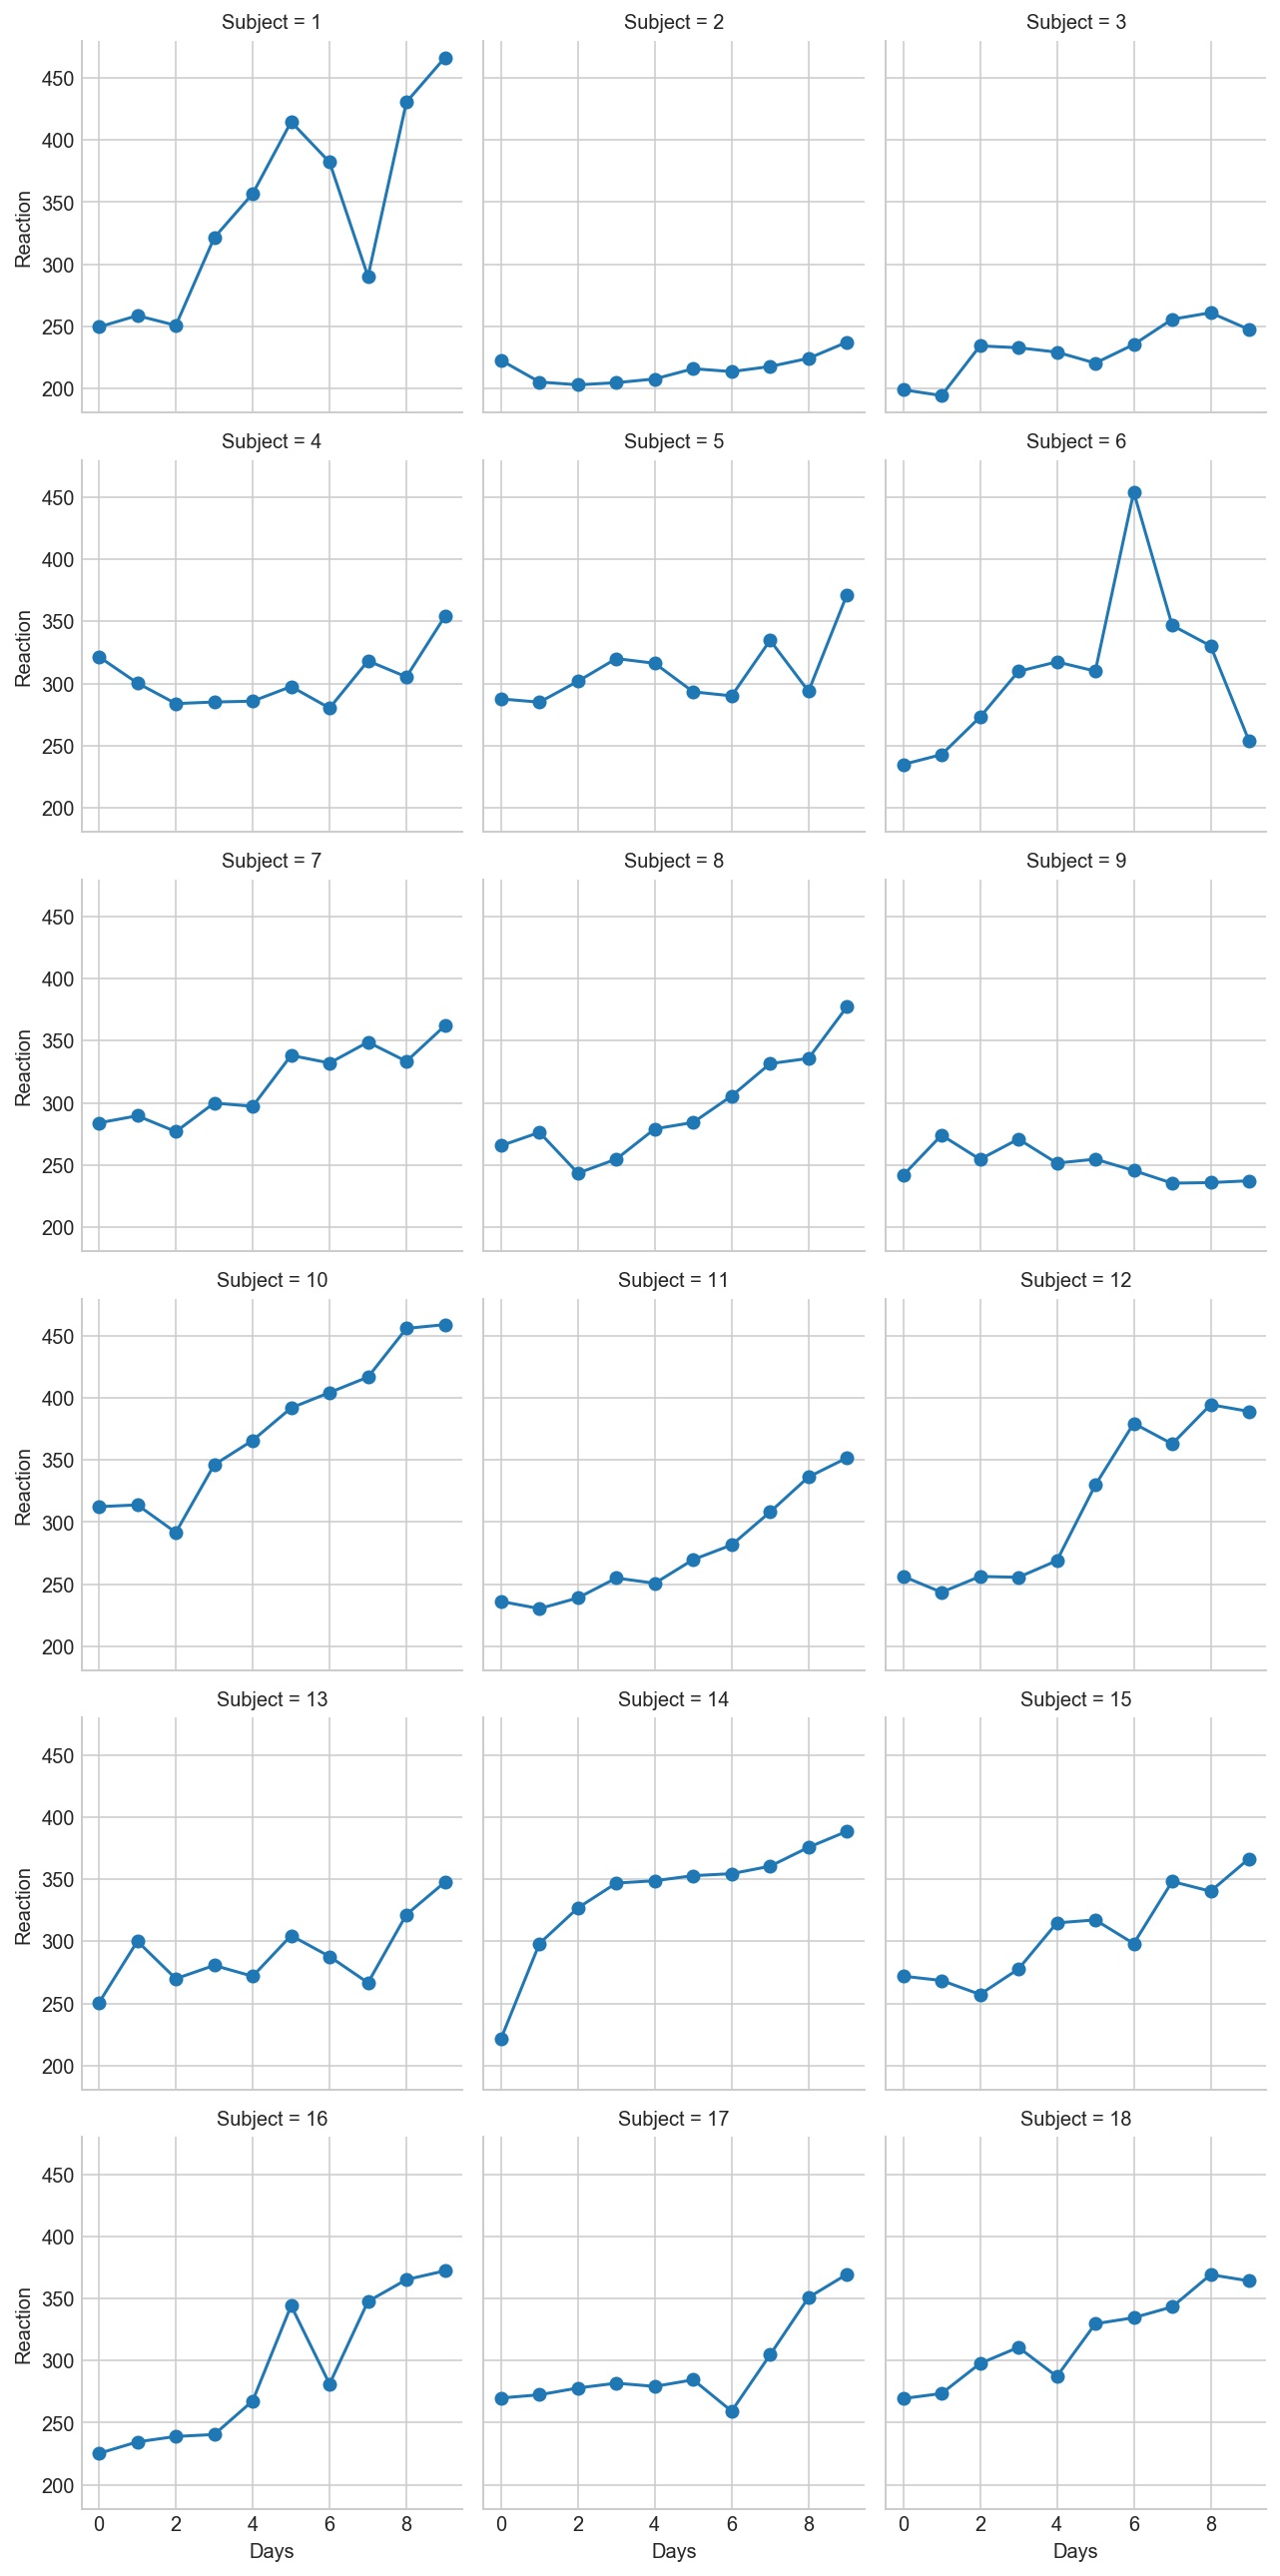

In [5]:
import seaborn as sns
%matplotlib inline

g = sns.FacetGrid(data, col="Subject",col_wrap=3)
g.map(plt.plot,"Days","Reaction",marker="o")

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


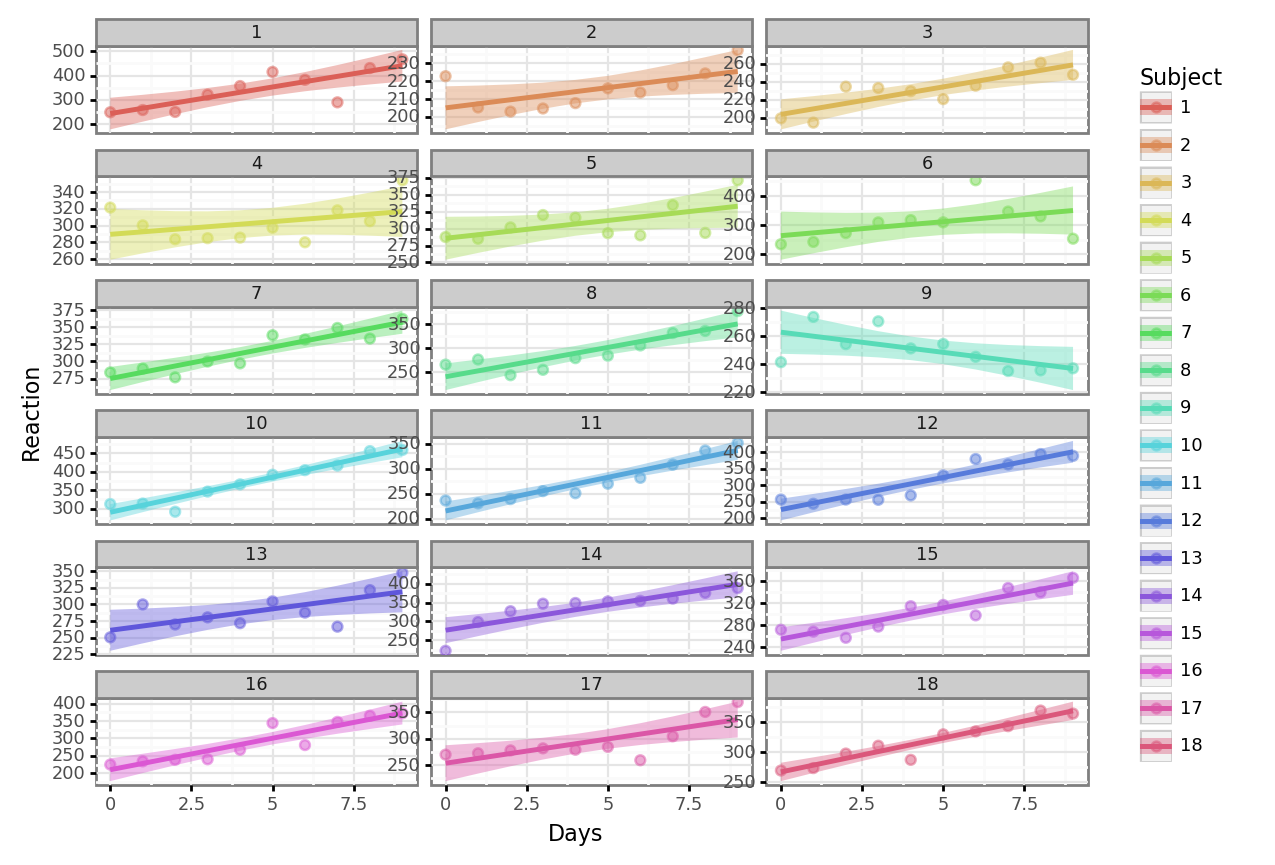

<ggplot: (107302061958)>

In [7]:
from plotnine import *

%matplotlib inline

(ggplot(data, aes(x='Days',y='Reaction',color='Subject',fill='Subject'))
 + geom_point(alpha=0.5)
 + stat_smooth(method="lm")
 + facet_wrap('~Subject',ncol=3,scales="free_y")
 + theme_bw(8))

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


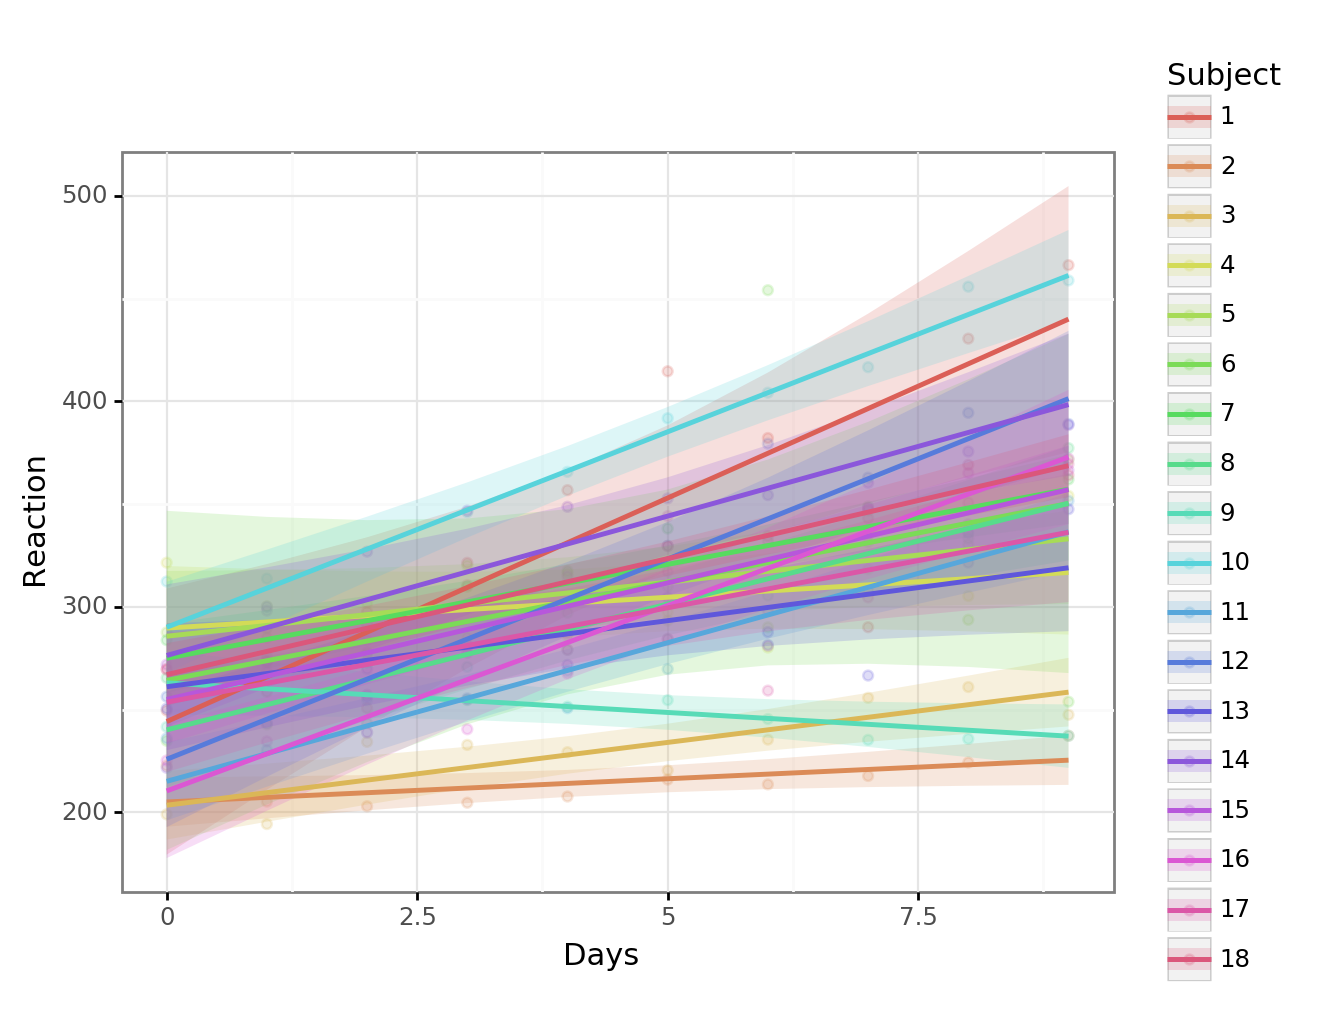

<ggplot: (-9223371929551848816)>

In [8]:
(ggplot(data, aes(x='Days',y='Reaction',color='Subject',fill='Subject'))
 + geom_point(alpha=0.2)
 + stat_smooth(method="lm",alpha=0.2)
 + theme_bw())

Thăm dò trực quan cho thấy giữa Reaction và Days có quan hệ tuyến tính, tuy nhiên đặc điểm của đồ thị hàm tuyến tính này (intercept và slope của nó) có thể thay đổi ở mỗi cá thể. Điều này gợi ý rằng ta cần 1 mô hình với random slope và random intercept để khảo sát hiệu ứng của thời gian mất ngủ (Days) đối với Reaction (fixed effect).Subject ID)

Mô hình này có dạng: Reaction ~ Days + (Days + 1)|Subject ID + error

Nếu xem mỗi cá thể là một phân nhóm trong nghiên cứu, ta thử làm thống kê mô tả cho Reaction ở từng cá thể. Hãy thử so sánh Mean và median, bạn sẽ thấy chúng khá gần nhau, và Reaction là 1 biến liên tục... ta có thể giả định rằng ở mỗi cá thể, Reaction có thể được ước lượng bằng 1 biến ngẫu nhiên Y có phân phối Gaussian.

In [9]:
data.groupby(['Subject'])['Reaction'].describe()

,count,mean,std,min,25%,50%,75%,max
Subject,,,,,,,,
1,10.0,342.13383,79.821763,249.5600,266.565675,339.14585,406.568525,466.3535
2,10.0,215.23298,10.812193,202.9778,205.878375,214.79605,221.482225,237.3142
3,10.0,231.00127,21.855996,194.3322,222.670275,233.58080,244.491675,261.0125
4,10.0,303.22142,22.909199,280.2396,285.299075,298.99285,315.033350,354.0487
5,10.0,309.43605,27.242607,285.0000,290.885925,297.78375,319.155800,371.5811
6,10.0,307.30207,64.306126,234.8606,258.638625,309.88320,327.090950,454.1619
7,10.0,316.15831,30.068208,276.7693,291.459000,315.91810,336.964875,362.0428
8,10.0,295.30205,41.855607,243.3647,268.155125,281.60780,325.023375,377.2990
9,10.0,250.07004,13.833852,235.3110,238.337025,248.45210,254.599825,273.9472


Do pyMC3 chạy trên nền Theano, một thư viện Deep learning như Tensorflow; ta cần phải chuẩn bị trước 2 chuyện: 

(1) thay đổi định dạng các biến trong mô hình cho phù hợp với quy ước đã đặt ra cho biến số trong Theano là 64 bit, (biến số nguyên = np.int64, biến liên tục = theano.config.floatX hoặc float64). 

(2) Ta tách riêng array subject_idx = mã cá thể và tạo ra 1 object tên là n_subj chỉ số lượng cá thể, từ biến Subject trong dữ liệu gốc.

In [10]:
import numpy as np
import pymc3 as pm
import theano

data['Reaction'] = data['Reaction'].astype(theano.config.floatX)
data['Days'] = data['Days'].astype(theano.config.floatX)
data['Subject'] = data['Subject'].astype(np.int64)

subj_idx = data.Subject.values

n_subj = len(data.Subject.unique())

In [11]:
subj_idx=subj_idx-1

subj_idx

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17], dtype=int64)

In [17]:
n_subj

18

Tiếp theo, Nhi xây dựng cấu trúc mô hình Bayes như sau:

Trong mô hình này, ta giả định là cả Intercept a và hệ số hồi quy b của Days (slope) đều biến đổi ngẫu nhiên tùy thuộc vào cá thể, mỗi cá thể được xem như 1 phân nhóm. 

Ta đặt 2 biến ngẫu nhiên: a = random intercept, b= hệ số hồi quy của Days (random slope), 

giả định a và b có phân bố Gaussian  với lần lượt 2 tham số mu_a, sigma_a, mu_b, sigma_b. Priors cho các tham số này lần lượt là: mu_a và mu_b có phân bố Gaussian  với µ=0, sd=100^2; sigma_a và sigma_b có phân bố HalfCauchy. Đây là những prior thuộc loại "weak informative priors", nhưng vẫn tốt hơn nhiều so với flat prior như uniform.

Một khi xác định được phân phối hậu nghiệm của mu_a và mu_b, xem như ta đã xác định được Fixed effect trong mô hình. Còn 18 giá trị a và b sẽ được xem như random effects (bao gồm random intercept: a và random slope : b).

Ta khai báo thêm sai số của mô hình: epsilon, với prior là phân phối HalfCauchy

Hàm likelihood của mô hình có nội dung: Reaction được ước lượng bằng 1 phân phối Gaussian, với Mu = a.subj_idx + b.subject_idx.Days , và SD = epsilon. Dữ liệu quan sát thực tế là vector Reaction trong data.

In [12]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_subj)
    # Intercept for each subject, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_subj)
    # Slope for each subject, distributed around group mean mu_b

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    React_est = a[subj_idx] + b[subj_idx] * data.Days.values

    # Data likelihood
    React_like = pm.Normal('Reac_like', mu=React_est, sd=eps, observed=data.Reaction)

Tiến trình suy diễn thống kê bắt đầu với 2 chuỗi MCMC, mỗi chuỗi 2500 lượt.

In [13]:
with hierarchical_model:
    hierarchical_trace = pm.sample(draws=2000, n_init=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [03:04<00:00, 13.53it/s]
The acceptance probability does not match the target. It is 0.8927481664680617, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8857939094139379, but should be close to 0.8. Try to increase the number of tuning steps.


Sau khi tiến trình này hoàn tất, ta chỉ việc trích xuất kết quả: Ta có phân phối hậu nghiệm của mu_a (fixed intercept), mu_b (fixed slope), 18 kiểu hình phân phối của Intercept (a1 đến a18), 18 kiểu phân phối của Slope (b1 đến b18), sigma_a, sigma_b và epsilon.

<IPython.core.display.Javascript object>


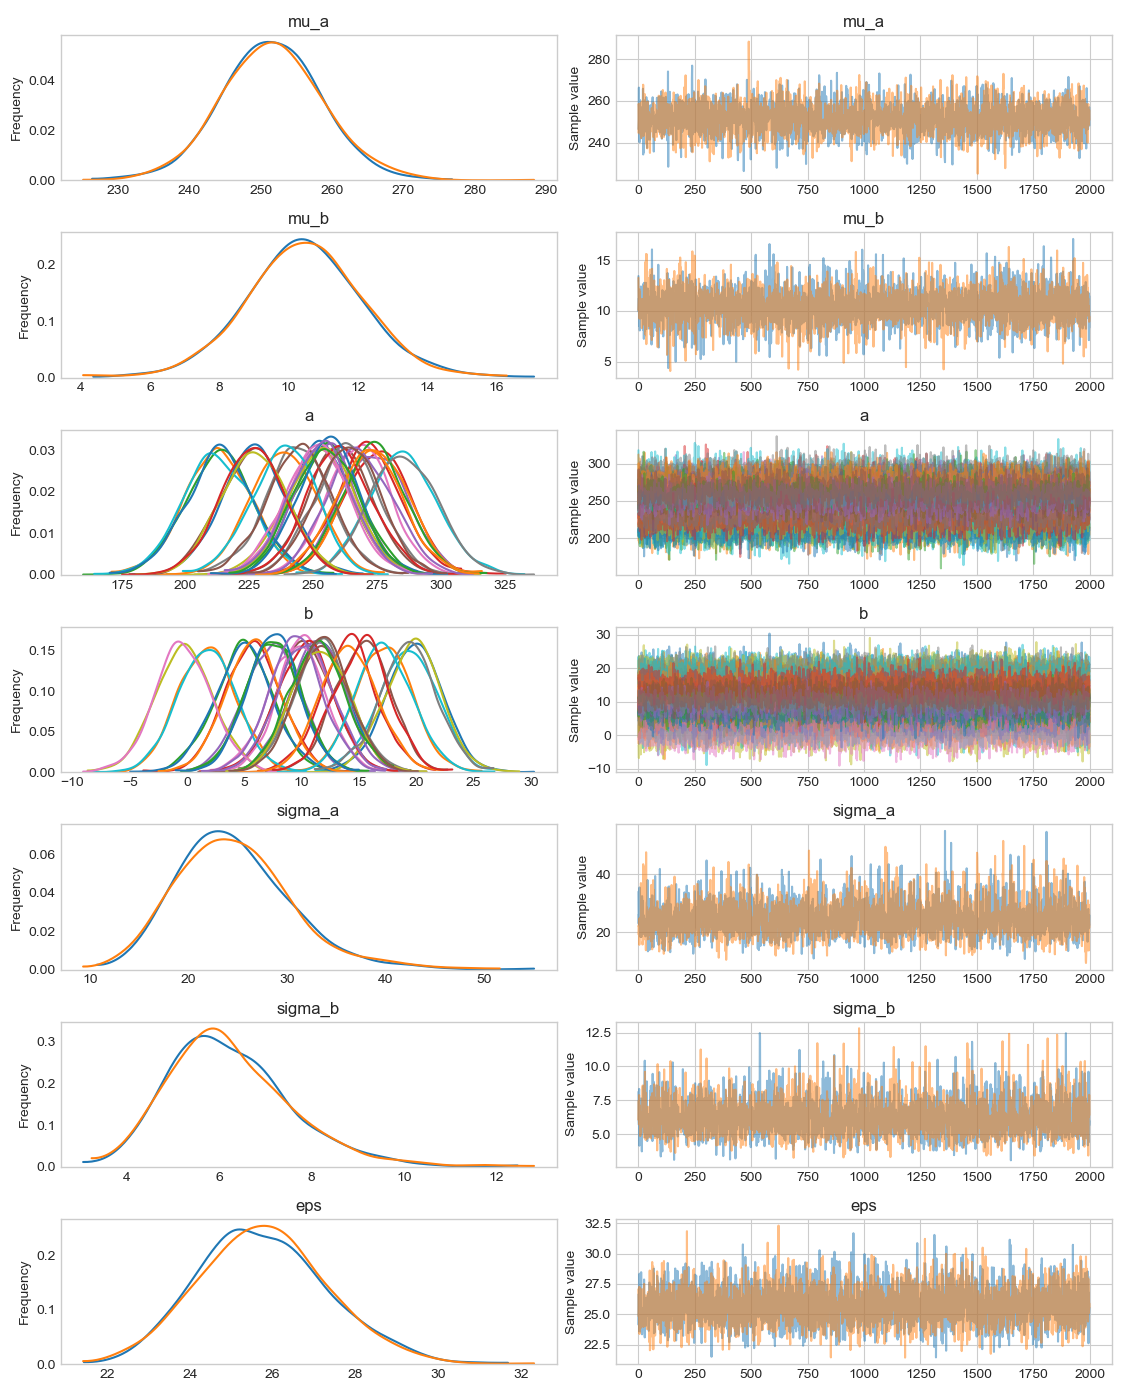

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DFBD762128>,
      dtype=object)

In [73]:
pm.traceplot(hierarchical_trace,alpha=0.5)

In [89]:
pm.summary(hierarchical_trace, alpha=.05).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,251.441,7.013,0.117,236.912,264.801,3805.105,1.0
mu_b,10.435,1.688,0.024,7.079,13.733,4466.882,1.0
a__0,253.017,12.490,0.176,229.419,277.997,5391.910,1.0
a__1,212.146,13.131,0.219,185.565,237.117,4111.148,1.0
a__2,213.341,13.267,0.248,186.635,238.833,3452.303,1.0
a__3,274.736,12.746,0.172,250.166,299.232,4326.418,1.0
a__4,273.534,12.651,0.159,250.127,299.292,5300.493,1.0
a__5,260.324,12.670,0.170,235.120,284.613,5880.051,1.0
a__6,267.969,12.464,0.169,243.755,292.140,4986.815,1.0
a__7,244.119,12.774,0.185,217.724,268.463,5102.887,1.0


Ta khảo sát riêng Random effects bằng 2 biểu đồ Forest, trước hết là Random Intercept

<IPython.core.display.Javascript object>


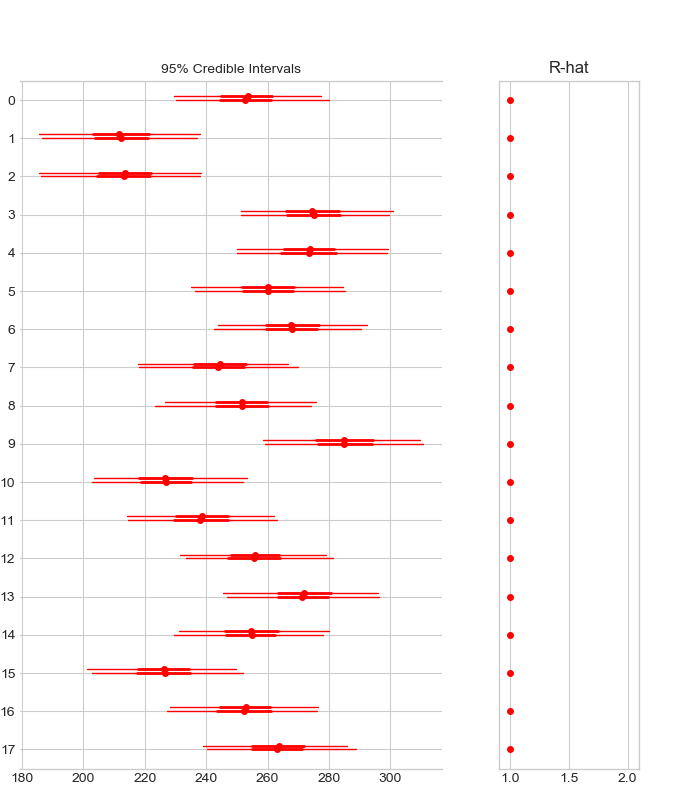

In [110]:
%matplotlib notebook

subj_names = data.Subject.unique()-1
subj_names = subj_names.astype(str)

pm.forestplot(hierarchical_trace, varnames=['a'], ylabels=subj_names, colors="red")

Và Random slopes

<IPython.core.display.Javascript object>


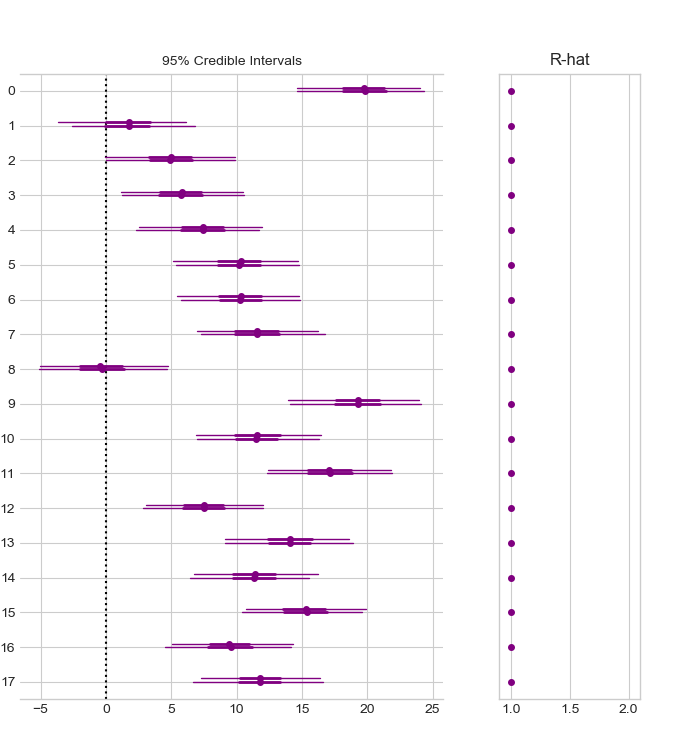

In [111]:
pm.forestplot(hierarchical_trace, varnames=['b'], ylabels=subj_names, colors="purple")

Còn đây là phân phối hậu nghiệm của Fixed effect, bao gồm Fixed intercept và Fixed slope:

<IPython.core.display.Javascript object>


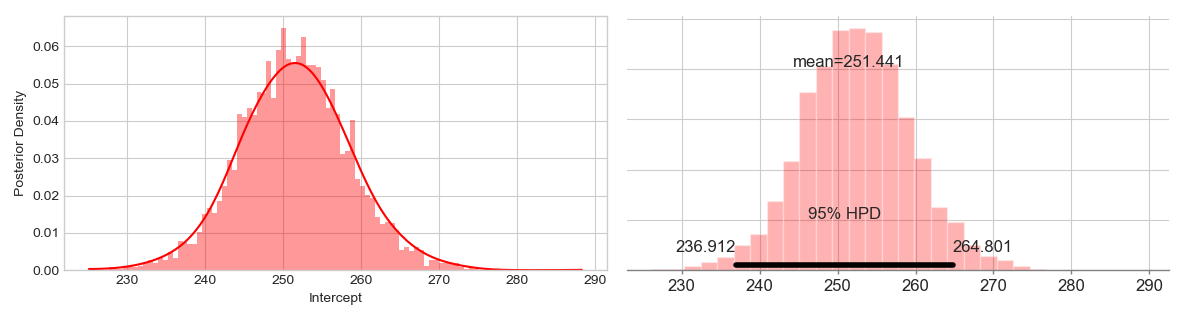

In [112]:
_, axes = plt.subplots(1, 2, figsize=(12,3))
pm.kdeplot(hierarchical_trace['mu_a'], ax=axes[0],color="red")
axes[0].hist(hierarchical_trace['mu_a'], bins=100, density=1, alpha=.4,color="red")
axes[0].set_xlabel('Intercept')
axes[0].set_ylabel('Posterior Density')

pm.plot_posterior(hierarchical_trace['mu_a'], ax=axes[1], color='red',alpha=0.3)
plt.tight_layout()

<IPython.core.display.Javascript object>


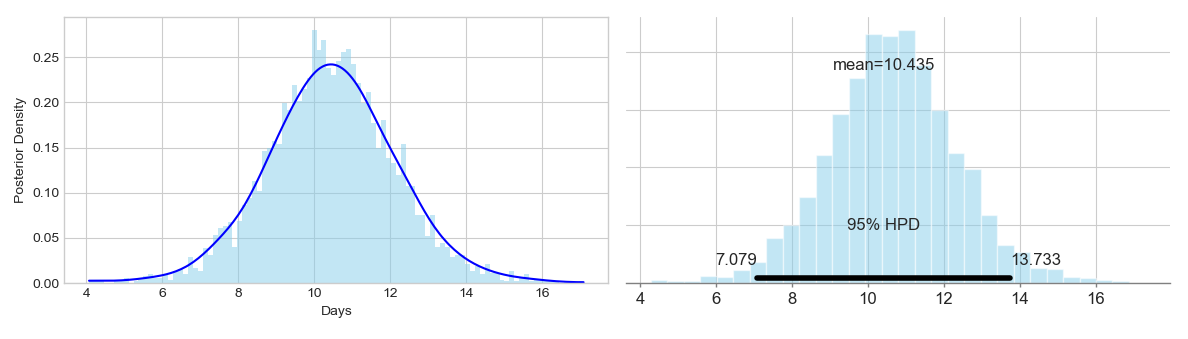

In [115]:
_, axes = plt.subplots(1, 2, figsize=(12,3))
pm.kdeplot(hierarchical_trace['mu_b'], ax=axes[0],color="blue")
axes[0].hist(hierarchical_trace['mu_b'], bins=100, density=1, alpha=.5,color="skyblue")
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Posterior Density')

pm.plot_posterior(hierarchical_trace['mu_b'], ax=axes[1], color='skyblue',alpha=0.5)
plt.tight_layout()

Đây là kết quả của mô hình tương đương khi dùng package lme4 trong ngôn ngữ R:

```
ml.model <- lmer(Reaction ~ Days + (1 + Days | Subject), sleepstudy)

## Linear mixed model fit by REML ['lmerMod']
## Formula: Reaction ~ Days + (1 + Days | Subject)
##    Data: sleepstudy
## 
## REML criterion at convergence: 1743.6
## 
## Scaled residuals: 
##     Min      1Q  Median      3Q     Max 
## -3.9536 -0.4634  0.0231  0.4634  5.1793 
## 
## Random effects:
##  Groups   Name        Variance Std.Dev. Corr
##  Subject  (Intercept) 612.09   24.740       
##           Days         35.07    5.922   0.07
##  Residual             654.94   25.592       
## Number of obs: 180, groups:  Subject, 18
## 
## Fixed effects:
##             Estimate Std. Error t value
## (Intercept)  251.405      6.825   36.84
## Days          10.467      1.546    6.77
## 
## Correlation of Fixed Effects:
##      (Intr)
## Days -0.138

fixef(ml.model)

## (Intercept)        Days 
##   251.40510    10.46729

ranef(ml.model)

## $Subject
##     (Intercept)        Days
## 308   2.2585637   9.1989722
## 309 -40.3985802  -8.6197026
## 310 -38.9602496  -5.4488792
## 330  23.6905025  -4.8143320
## 331  22.2602062  -3.0698952
## 332   9.0395271  -0.2721709
## 333  16.8404333  -0.2236248
## 334  -7.2325803   1.0745763
## 335  -0.3336936 -10.7521594
## 337  34.8903534   8.6282835
## 349 -25.2101138   1.1734148
## 350 -13.0699598   6.6142055
## 351   4.5778364  -3.0152574
## 352  20.8635944   3.5360130
## 369   3.2754532   0.8722166
## 370 -25.6128737   4.8224653
## 371   0.8070401  -0.9881551
## 372  12.3145406   1.2840295

```

Bài thực hành đến đây là hết, như ta thấy, mô hình Bayes với pyMC3 giải quyết rất mỹ mãn bài toán hồi quy phân cấp (còn gọi là Generalized linear Mixed model). Trong trường hợp này, biến kết quả có phân bố chuẩn, nhưng ta hoàn toàn có thể áp dụng những phân phối khác như log normal, t, hoặc negative binomial... Mô hình hồi quy phân cấp là một công cụ rất quan trọng trong nghiên cứu y học, bao gồm các thử nghiệm lâm sàng, nghiên cứu trường diễn, hoặc phân tích tổng hợp (meta analysis).